Goal: using the MNIST dataset, 
* play around with and assess performance of various classifiers, simple and complex
* utilize / familiarize oneself with built-in scikitlearn tools (e.g. grid search, model pipelines, preprocessing tools, etc)

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from keras.datasets import mnist
from sklearn.linear_model import LogisticRegression as LReg

C:\Users\Gerry\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
C:\Users\Gerry\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Simple stuff: how is the MNIST dataset represented by scikitlearn as a builtin dataset

In [2]:
# first let's load the MNIST dataset
digits = datasets.load_digits()

In [4]:
# hmm...it's of 'Bunch' datatype
type(digits)

sklearn.utils.Bunch

In [5]:
type(digits.images) # as expected and hoped, images is a numpy array

numpy.ndarray

In [6]:
digits.images.shape # ...of nsamples and 8x8 pix
# ...hmm this is a low res version of MNIST

(1797, 8, 8)

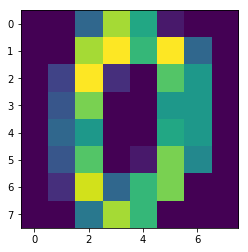

In [7]:
plt.imshow(digits.images[0,:,:])

In [12]:
# images are in float64?!
type(digits.images[0,0,0])

numpy.float64

(array([60367.,  6240.,  3261.,  5362.,  2627.,  6049.,  5556.,  3668.,
         7118., 14760.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

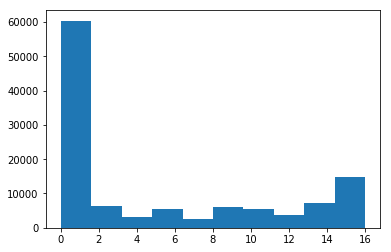

In [17]:
# but all numbers are from 0 to 16, so clearly the float64 wasn't really
# necessary...prob useful in case you forget to convert from, e.g. uint8
plt.hist(digits.images.flatten())

In [27]:
# the digit labels are in digits.target, it seems
print(digits.target.shape)
digits.target[0:20]

# note how the digits seem to be in order
#...we'll of course need to do some shuffling later

(1797,)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [29]:
np.reshape?

In [87]:
# we'll need to reshape the digits to a nsamples by npix array
ImagesShape = digits.images.shape
#FlatImages = np.reshape(digits.images,(ImagesShape[0],ImagesShape[1]*ImagesShape[2]))
#shortcut reshaping
FlatImages = np.reshape(digits.images,(ImagesShape[0],-1))
FlatImages.shape

(1797, 64)

Scikitlearn utilities of interest (appended as I run into them through this exercise)
* `Bunch` objects
* ShuffleSplit (`sklearn.model_selection.ShuffleSplit`)

Model training: simple to complex

1) Simple logistic regression

In [33]:
MyLRegModel = LReg() # instantiate the model with default parameters
'''note:
LReg expects the first argument to be X training samples to be (nsamples,nfeatures)
and the second argument to be y training labels (nsamples,)

LReg also seems to shuffle the data by default, as well as implement L2 
regularization by default

Note that we technically have a multiclass problem here, and it seems like the
default is to do a one vs all binary classification (so technically 10
classifiers were trained --> see model.coef_)
'''
MyLRegModel.fit(FlatImages,digits.target) # train the model on all the data!

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [81]:
MyLRegModel.coef_.shape

(10, 64)

Remember that a logistic regression is trying to learn some weight for each input pixel to help best predict an output class. If this were just a binary classification problem, the shape of the model coefficients would be `(1,64)`. But since this is a multi-class problem, and since default LogisticRegression behavior is to solve a binary classification problem, you essentially train 10 classifiers (one for each digit class). And so we have coefficients of shape `(10,64)`.

In [35]:
# how well did we do?
MyLRegModel.score(FlatImages,digits.target)

0.993322203672788

`Model.score()` computes a score on given input data, so by feeding in the entire training data, it's not surprising that the model performed really really well. That said, it didn't perform with 100% accuracy. I'm actually curious as to what errors it still made.

In [38]:
# compute number of examples model mis-classified
(1-0.993)*1797

12.579000000000011

The model misclassified about 12-13 examples (not sure why this isn't a whole number, but we'll figure that out). Can we see what these were?

In [46]:
# this is the model's predictions, should be of len = nsamples
print(MyLRegModel.predict(FlatImages).shape)
Predictions = MyLRegModel.predict(FlatImages)

(1797,)


In [56]:
# get indices where our Prediction doesn't match the label
ErrorIndices = np.where(Predictions != digits.target)
ErrorIndices

# ...thankfully Predictions and digits.target are in the same order since we
# didn't shuffle the data when asking for predictions

(array([  69,  129,  172,  215,  275,  524,  794, 1149, 1553, 1571, 1658,
        1747], dtype=int64),)

In [58]:
# so there are 12 mislabeled images
ErrorIndices[0].shape

(12,)

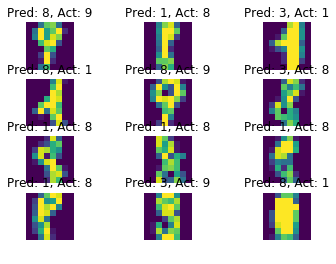

In [70]:
for a,index in enumerate(ErrorIndices[0]):
    plt.subplot(4,3,a+1)
    plt.axis('off')
    plt.title('Pred: ' + str(Predictions[index]) + ', Act: ' + str(digits.target[index]))
    plt.imshow(digits.images[index])

To be honest, I can't even tell the real label for some of this. Like that big blob of 8 in the lower right corner? Yikes. These downsampled images are not great in that respect. Though it's true that it's slightly easier to discern the label if we make the images really small and observe this as a sort of tiny mosaic.

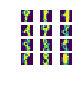

In [71]:
plt.figure(figsize=(1,1))
for a,index in enumerate(ErrorIndices[0]):
    plt.subplot(4,3,a+1)
    plt.axis('off')
    plt.imshow(digits.images[index])

It's also interesting to note the errors were exclusively on digits 1,8,9---especially 8. Which is probably not surprising, since 8 is likely the most sensitive to downsampling (which could blot out either of the two holes).

I'm curious if we can get 100% accuracy if we just feed in a higher resolution version of MNIST. For that, I know Keras has a higher res version built in.

In [73]:
# load the dataset from keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

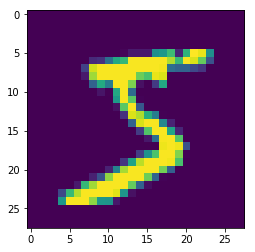

In [82]:
plt.imshow(x_train[0,:,:])
# mm..much nicer 28x28 (>3x larger) resolution

In [74]:
x_train.shape

(60000, 28, 28)

Ok, well, this is a bit too large of a dataset. I don't really want to try 60k examples

In [76]:
# thankfully it seems like the dataset is already shuffled, so I could 
# presumably just take the first 1797 samples
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

In [88]:
NewX = x_train[:1797]
NewXShape = NewX.shape
NewX = np.reshape(NewX,(NewXShape[0],-1))
NewY = y_train[:1797]
print(NewX.shape)
print(NewY.shape)

(1797, 784)
(1797,)


In [89]:
MyLRegModel2 = LReg().fit(NewX,NewY)

In [91]:
MyLRegModel2.score(NewX,NewY)

1.0

Aha! As I suspected. Now with higher res images where the ground truth is actually discernable, we get 100% accuracy when training a model that is 100% overfit to the data. This is an important point, because it helps us understand that the upper bound on model performance was not because of model choice per se, but rather data quality. 

In more formal terminology, the Bayes Error is 0 for the 28x28 pixel images, but nonzero for the 8x8 pixel images. 